In [ ]:
!pip install --force-reinstall numpy==1.26.4

In [8]:
import numpy as np
np.float = np
np.int = np

In [9]:
import sys
import numpy as np
import pandas as pd
from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.data.data_stream import DataStream
from sklearn.metrics import accuracy_score, f1_score, classification_report
from D3 import D3
import pickle
import warnings

warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('경진대회용 주조 공정최적화 데이터셋.csv', encoding = 'euc-kr', index_col = 0)
df.dropna(subset=['emergency_stop', 'upper_mold_temp3','lower_mold_temp3'], inplace=True)
df = df[['registration_time','facility_operation_cycleTime','production_cycletime', 'low_section_speed', 'high_section_speed','cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3','lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3','sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time','passorfail']]
df['registration_time'] = pd.to_datetime(df['registration_time'])
display(df)

C:\Users\bongj\AppData\Local\Temp\ipykernel_5852\1491360016.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('경진대회용 주조 공정최적화 데이터셋.csv', encoding = 'euc-kr', index_col = 0)


,registration_time,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail
0,2019-01-02 16:45:06,119,120,110.0,112.0,331.0,35.0,198.0,116.0,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0
22,2019-01-02 17:27:28,119,120,109.0,125.0,177.0,48.0,24.0,33.0,1449.0,30.0,273.0,1449.0,479.0,708.0,35.0,23,1.0
24,2019-01-02 17:29:32,119,123,109.0,112.0,176.0,49.0,26.0,55.0,1449.0,30.0,323.0,1449.0,513.0,700.0,35.0,23,1.0
26,2019-01-02 17:31:41,119,124,109.0,112.0,331.0,47.0,31.0,65.0,1449.0,30.0,343.0,1449.0,531.0,708.0,34.0,23,1.0
28,2019-01-02 17:33:39,120,124,110.0,112.0,331.0,46.0,36.0,73.0,1449.0,31.0,343.0,1449.0,544.0,707.0,34.0,23,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,2019-03-31 23:51:29,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0
92011,2019-03-31 23:53:28,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0
92012,2019-03-31 23:55:44,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0
92013,2019-03-31 23:57:46,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0


In [5]:
train_df = df[df['registration_time'] <= '2019-01-30 08:00:00']
test_df = df[df['registration_time'] > '2019-01-30 08:00:00']
train_X = train_df.drop(['registration_time','passorfail'],axis=1)
train_y = train_df['passorfail']
test_X = test_df.drop(['registration_time','passorfail'],axis=1)
test_y = test_df['passorfail']

print(train_df.shape)
print(test_df.shape)

(26461, 18)
(65241, 18)


## Random Forest

### Offline model

In [ ]:
#random forest
model = AdaptiveRandomForestClassifier(n_estimators=100, drift_detection_method = None, warning_detection_method= None, random_state=4)
model.fit(train_X.values, train_y.values)

y_pred = model.predict(test_X.values)
accuracy = accuracy_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)
report = classification_report(test_y, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.9659110068821753
F1 Score: 0.6107805390269514
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     62354
         1.0       0.62      0.60      0.61      2887

    accuracy                           0.97     65241
   macro avg       0.80      0.79      0.80     65241
weighted avg       0.97      0.97      0.97     65241



In [ ]:
test_y = test_y
chunk_num = 30
chunk_size = len(y_pred) // chunk_num

acc_list = []
f1_list = []

for i in range(chunk_num):
    start_idx = i*chunk_size
    end_idx = (i+1)*chunk_size
    if i == (chunk_num-1):
        chunk_y = test_y[start_idx:]
        chunk_pred = y_pred[start_idx:]
    else:
        chunk_y = test_y[start_idx:end_idx]
        chunk_pred = y_pred[start_idx:end_idx]

    acc_list.append(accuracy_score(chunk_y, chunk_pred))
    f1_list.append(f1_score(chunk_y, chunk_pred))

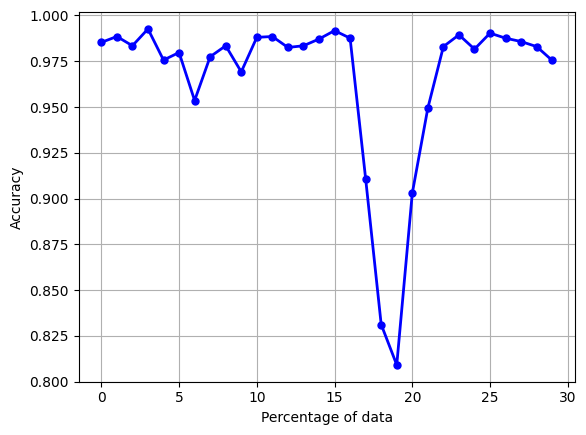

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(30), acc_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Percentage of data')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

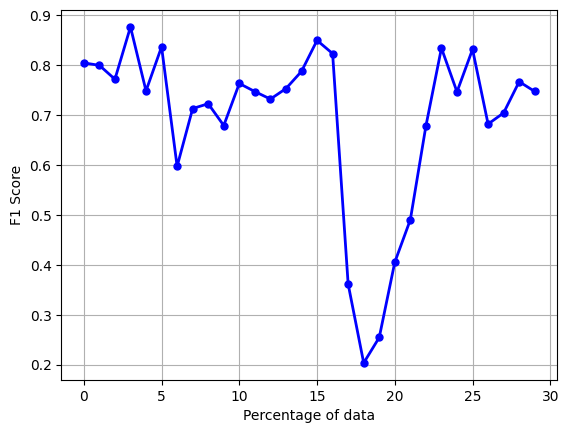

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(30), f1_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Percentage of data')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
#Save model
with open('model_params/20190130_0800_adaptiverf.pkl', 'wb') as file:
    pickle.dump(model, file)

### Online

In [10]:
#load model
with open('model_params/20190130_0800_adaptiverf.pkl', 'rb') as file:
    model = pickle.load(file)

In [ ]:
pred_li = []
i = 0
w_size = 400
rho = 0.5

stream = DataStream(data = test_X, y= test_y.values)
d3 = D3(w=w_size, rho=rho, dim = 16, auc = 0.85)

for x,y in zip(train_X.values[-w_size:,:],train_y.values[-w_size:]):
  d3.addInstance(x,y)

while(stream.has_more_samples()):
  X,y = stream.next_sample()
  if d3.isEmpty():
    d3.addInstance(X,y)
    y_hat = model.predict(X)
    pred_li.append(y_hat.item())
  else:
    if d3.driftCheck():
      print("concept drift detected at {}".format(i))
      y_hat = model.predict(X)
      model.partial_fit(d3.getCurrentData(), d3.getCurrentLabels())
      pred_li.append(y_hat.item())
      d3.addInstance(X,y)

    else:
      y_hat = model.predict(X)
      pred_li.append(y_hat.item())
      d3.addInstance(X,y)
  i = i+1

#print(pred_li)
#save_result = pd.DataFrame(pred_li)
#save_result.to_csv('/content/drive/MyDrive/KAMP_제출용/예측 결과 저장/20190116_0800_adaptiverf_online.csv')

concept drift detected at 200
concept drift detected at 1000
concept drift detected at 2000
concept drift detected at 2600
concept drift detected at 3200
concept drift detected at 3800
concept drift detected at 4400
concept drift detected at 4800
concept drift detected at 5200
concept drift detected at 5600
concept drift detected at 6000
concept drift detected at 6600
concept drift detected at 7200
concept drift detected at 7800
concept drift detected at 8400
concept drift detected at 8800
concept drift detected at 9400
concept drift detected at 9800
concept drift detected at 10200
concept drift detected at 10600
concept drift detected at 11000
concept drift detected at 11400
concept drift detected at 11800
concept drift detected at 12400
concept drift detected at 12800
concept drift detected at 13400
concept drift detected at 13800
concept drift detected at 14200
concept drift detected at 14600
concept drift detected at 15000
concept drift detected at 15400
concept drift detected at 1

In [ ]:
#w = 400, rho = 0.5, thr = 0.85
accuracy = accuracy_score(test_y, pred_li)
f1 = f1_score(test_y, pred_li)
report = classification_report(test_y, pred_li)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.9831854202112169
F1 Score: 0.7710290127322063
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     62354
         1.0       0.97      0.64      0.77      2887

    accuracy                           0.98     65241
   macro avg       0.98      0.82      0.88     65241
weighted avg       0.98      0.98      0.98     65241



In [ ]:
test_y = test_y
chunk_num = 30
chunk_size = len(test_y) // chunk_num

acc_list = []
f1_list = []

for i in range(chunk_num):
    start_idx = i*chunk_size
    end_idx = (i+1)*chunk_size
    if i == (chunk_num-1):
        chunk_y = test_y[start_idx:]
        chunk_pred = pred_li[start_idx:]
    else:
        chunk_y = test_y[start_idx:end_idx]
        chunk_pred = pred_li[start_idx:end_idx]

    acc_list.append(accuracy_score(chunk_y, chunk_pred))
    f1_list.append(f1_score(chunk_y, chunk_pred))

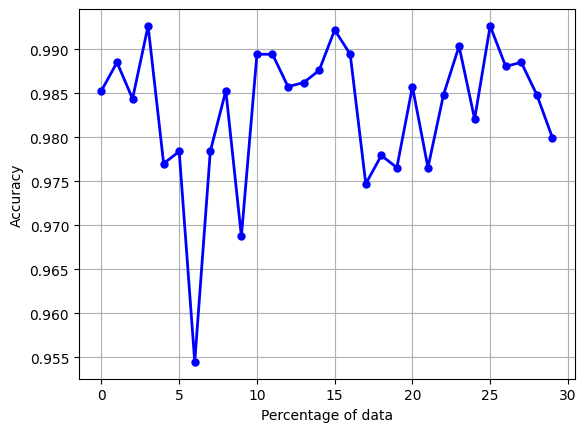

In [ ]:
#w = 400, rho = 0.5, thr = 0.85
import matplotlib.pyplot as plt

plt.plot(range(30), acc_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Percentage of data')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

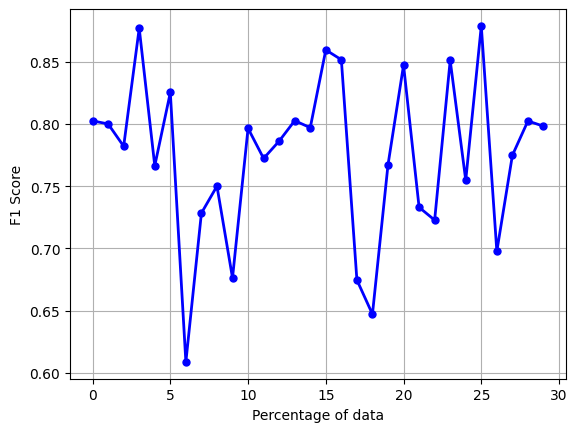

In [ ]:
#w = 400, rho = 0.5, thr = 0.85
import matplotlib.pyplot as plt

plt.plot(range(30), f1_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Percentage of data')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

### 시각화

In [ ]:
on_pred = pred_li
off_pred = y_pred

chunk_num = 30
chunk_size = len(test_y) // chunk_num

on_acc_list = []
on_f1_list = []
off_acc_list = []
off_f1_list = []

for i in range(chunk_num):
    start_idx = i*chunk_size
    end_idx = (i+1)*chunk_size
    if i == (chunk_num-1):
        chunk_y = test_y[start_idx:]
        on_chunk_pred = on_pred[start_idx:]
        off_chunk_pred = off_pred[start_idx:]
    else:
        chunk_y = test_y[start_idx:end_idx]
        on_chunk_pred = on_pred[start_idx:end_idx]
        off_chunk_pred = off_pred[start_idx:end_idx]

    on_acc_list.append(accuracy_score(chunk_y, on_chunk_pred))
    off_acc_list.append(accuracy_score(chunk_y, off_chunk_pred))
    on_f1_list.append(f1_score(chunk_y, on_chunk_pred))
    off_f1_list.append(f1_score(chunk_y, off_chunk_pred))

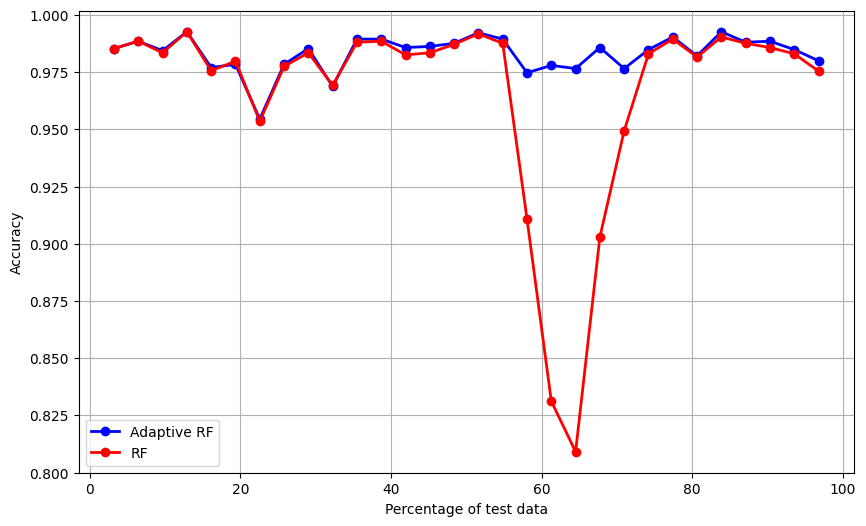

In [ ]:
plt.figure(figsize=(10, 6))

xlabel = np.linspace(0, 100, 32)[1:-1]
plt.plot(xlabel, on_acc_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=6, label = 'Adaptive RF')
plt.plot(xlabel, off_acc_list, marker='o', color='r', linestyle='-', linewidth=2, markersize=6, label = 'RF')
plt.xlabel('Percentage of test data')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

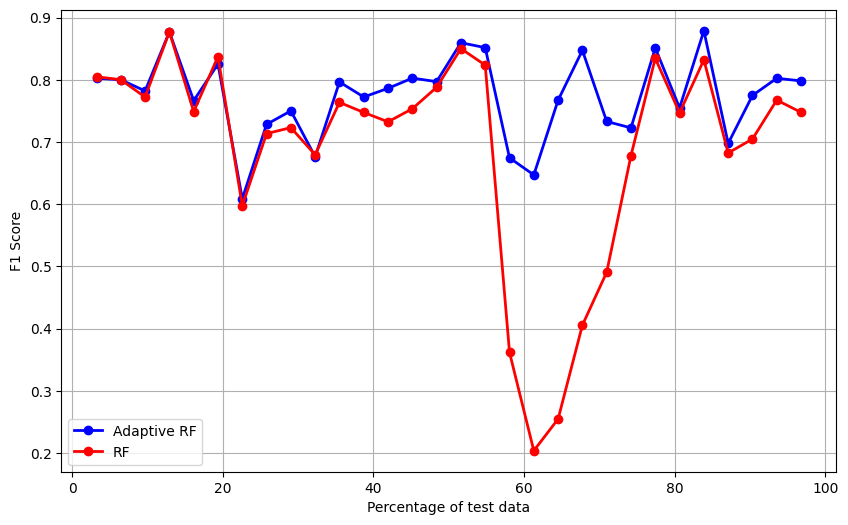

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

xlabel = np.linspace(0, 100, 32)[1:-1]
plt.plot(xlabel, on_f1_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=6, label = 'Adaptive RF')
plt.plot(xlabel, off_f1_list, marker='o', color='r', linestyle='-', linewidth=2, markersize=6, label = 'RF')
plt.xlabel('Percentage of test data')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_y.values

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
rf_perf = pd.DataFrame()
rf_perf['online_pred'] = pred_li
rf_perf['offline_pred'] = y_pred
rf_perf['ground_truth'] = test_y.values

In [ ]:
rf_perf.to_csv('pred_results/20190130_0800_RF_result(400,0.5,0.85).csv')